In [1]:
import os
import traceback
import numpy as np
from numpy import linalg as LA

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


In [2]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp_grad/"

In [3]:
seed = 42

In [4]:
dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradient = False                         # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor

Generate a specific set of samples we want to use.
Right now we want 10 samples of data with labels 2 and 4.

In [5]:
# MNIST DATA 

# n_samples = 20             # How much to sample from each class
# dataX, dataLabels = load_mnist(data_home=data_home)
# print(dataX.shape, dataLabels.shape)

# indices_2 = np.where(dataLabels == 2)
# indices_4 = np.where(dataLabels == 4)

# samples_idx_2 = np.random.choice(indices_2[0], size=n_samples, replace=False)
# samples_idx_4 = np.random.choice(indices_4[0], size=n_samples, replace=False)

# print(samples_idx_2)
# print(samples_idx_4)

# print(dataLabels[samples_idx_2])
# print(dataLabels[samples_idx_4])

# labels_2 = dataLabels[samples_idx_2]
# labels_4 = dataLabels[samples_idx_4]
# sample_labels = np.concatenate((labels_2, labels_4), axis=0)

# samples_2 = dataX[samples_idx_2]        # samples of number 2
# samples_4 = dataX[samples_idx_4]        # samples of number 4
# sample_data = np.concatenate((samples_2, samples_4), axis=0)    # Contains both 2 and 4 

# print(sample_data.shape)    

Custom data with 2 very dense clusters that are far apart from eachother

In [6]:
# Custom data, Multivariate distrib.
# from scipy.stats import multivariate_normal

# n_samples = 100
# n_dims = 50
# loc = 1000

# mu_1 = np.ones(n_dims) * (-loc)
# cov_1 = np.identity(n_dims) * 100
# cluster_1 = multivariate_normal.rvs(mean=mu_1, cov=cov_1, size=n_samples)

# mu_2 = np.ones(n_dims) * loc 
# cov_2 = np.identity(n_dims)
# cluster_2 = multivariate_normal.rvs(mean=mu_2, cov=cov_2, size=n_samples)

# print(cluster_1.shape)      # 10 samples in each cluster
# print(cluster_2.shape)

# dataX = np.concatenate((cluster_1, cluster_2), axis=0)

# labels = [0 for _ in range(n_samples)] + [1 for _ in range(n_samples)]
# dataLabels = np.array(labels)

In [48]:
# Custom data, Uniform distrib.

from scipy.stats import uniform 
n_samples = 500
n_dim = 10
b1 = 1000000
b2 = 100

# Bounds for first distribution
lb_1 = np.ones(n_dim) * (-b1)
ub_1 = np.ones(n_dim) * (-b2)
widths_1 = ub_1 - lb_1 

# Bounds for 2nd distribution
lb_2 = np.ones(n_dim) * b2
ub_2 = np.ones(n_dim) * b1
widths_2 = ub_2 - lb_2

# Draw samples 
samples_1 = uniform.rvs(loc=lb_1, scale=widths_1, size=(n_samples, n_dim))
samples_2 = uniform.rvs(loc=lb_2, scale=widths_2, size=(n_samples, n_dim))

dataX = np.concatenate((samples_1, samples_2), axis=0)
labels = [0 for _ in range(n_samples)] + [1 for _ in range(n_samples)]
dataLabels = np.array(labels)

Get the distance matrix and affinity matrix of our samples

In [49]:
hd_params = {"perplexity": n_samples}

D, V = hd_matrix(X=dataX, D=None, V=None,
                    knn_method="sklearn", metric="euclidean", n_neighbors=10, knn_params=None,
                    hd_method="vdm2008", hd_params=hd_params, verbose=1)

Computing the kNN D matrix with k=999 nearest neighbors...
Using sklearn NearestNeighbor, an exact method, for the knn computation
Indexed 1000 samples in 0.000s...
Computed neighbors for 1000 samples in {duration:.3f}s...
`hd_method` set to `vdm2008`, running with perplexity 500. Returns (D, V)
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1364603.500000


In [44]:
print(D.shape)
print(V.shape)

(200, 200)
(200, 200)


In [50]:
# Initialize embedder

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 100
main_iterations = 100
cf = HyperbolicKL

# Compute initial embedding in Poincare disk (PCA embedding)
X_embedded = initialization(
    n_samples=dataX.shape[0], 
    n_components=2,
    X=dataX,
    random_state=seed,
    method="random"
) 

# Initialize config and parameters
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact)
opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
opt_params, opt_conf = initialize_logger(log_path, grad_path, opt_params, opt_conf)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.08333333333333333, 'learning_rate_main': 0.08333333333333333, 'exaggeration': 12, 'exaggeration_its': 100, 'gradientDescent_its': 100, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True}


In [51]:
# Set up H-TSNE object 
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer,         # the optimizater we use
    opt_params=opt_params              # the parameters for the optimizers
)

# Compute embedding:
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 38.06511 grad_norm: 4.65479e-01: 100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


Running Gradient Descent, Verbosity: True
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.47453 grad_norm: 1.92630e-02: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


temp/poincare/
temp/poincare/solver_gradient_descent_sequential_opt_0
temp/poincare/solver_gradient_descent_sequential_opt_1
Animation being saved to: results/gradient_vis_images/sample2_4_images.gif


Animating:   0%|          | 0/20 [00:00<?, ?it/s]f:\School\TU_DELFT_THESIS\hyperbolic-tsne\hyperbolicTSNE\visualization.py:323: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=20.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 23it [00:01, 12.60it/s]                      


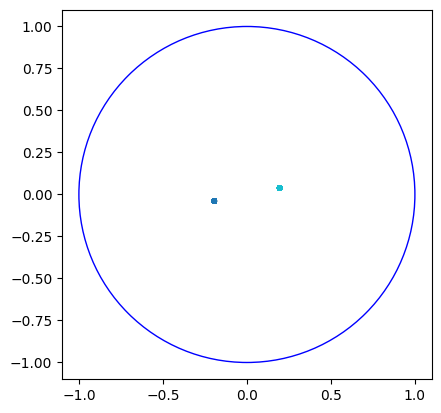

In [52]:
save_folder = "results/gradient_vis_images"
file_name = f"{save_folder}/sample2_4_images"
store_visuals(hyperbolicEmbedding, dataLabels, save_folder, file_name, opt_params)